# FEV vs. Alpha Analysis

For each SimCLR layer, this notebook plots **mean FEV** vs. **alpha** (where alpha is the slope of the log–log PCA variance spectrum).

- **Mean FEV** is taken from the regression: SimCLR features (reduced to N PCs) → Neural data (original dimensionality)

- For each layer, we select the **best FEV** (i.e., highest across PC counts)

In [1]:
from cortexlib.power_law import PowerLawAlphaEstimator
from cortexlib.mouse import CortexlabMouse
from cortexlib.utils import file as futils
from cortexlib.utils.logging import Logger
from cortexlib.utils.random import set_global_seed, GLOBAL_SEED
from cortexlib.utils.plotting import simclr_colours
from sklearn.decomposition import PCA
from adjustText import adjust_text
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import torch

logger = Logger()
set_global_seed()

In [2]:
MOUSE_ID = futils.get_mouse_id()
logger.info(f"This notebook is running for mouse {MOUSE_ID}")

16:21:47 | INFO     | ℹ️ This notebook is running for mouse m01_d2


In [3]:
mouse = CortexlabMouse(mouse_id=MOUSE_ID)

logger.progress(f"Computing null distributions for all neurons in mouse {mouse.id}")
null_srv_all_neurons = mouse.compute_null_all_neurons(n_shuffles=100)
logger.success(f"Null distributions computed")

real_srv_all_neurons = mouse.compute_real_srv_all_neurons()
reliable_neuron_indices = mouse.get_reliable_neuron_indices(
            null_srv_all_neurons, real_srv_all_neurons, percentile_threshold=99)
neural_responses_mean, neural_responses, _ = mouse.get_responses_for_reliable_neurons(reliable_neuron_indices, real_srv_all_neurons, num_neurons=500)

logger.info(f"Neural responses shape: {neural_responses.shape}")

16:21:47 | INFO     | ⏳ Computing null distributions for all neurons in mouse m01_d2...
16:22:13 | SUCCESS  | ✅ Null distributions computed!
16:22:13 | INFO     | ℹ️ Neural responses shape: (1380, 2, 500)


In [4]:
neural_plae = PowerLawAlphaEstimator()

rep1 = neural_responses[:, 0, :]
rep2 = neural_responses[:, 1, :]
neural_alpha_filtered_neurons = neural_plae.compute_cv_alpha_rank(
    rep1, rep2, kmin=11, kmax=min(500, rep1.shape[1]),
    log_spaced=True, npts=100
)

raw_neural_responses = mouse.neural_responses
raw_neural_responses_mean = raw_neural_responses.mean(axis=1) 
raw_rep1 = raw_neural_responses[:, 0, :]
raw_rep2 = raw_neural_responses[:, 1, :]
neural_alpha_all_neurons = neural_plae.compute_cv_alpha_rank(
    raw_rep1, raw_rep2,
    kmin=11, kmax=min(500, raw_rep1.shape[1]),
    log_spaced=True, npts=100
)

alpha_data = {
    'mouse_id': MOUSE_ID,
    'alpha_all_neurons': neural_alpha_all_neurons.alpha,
    'r2_all_neurons': neural_alpha_all_neurons.r2,
    'n_all_neurons': raw_neural_responses.shape[2],
    'alpha_filtered_neurons': neural_alpha_filtered_neurons.alpha,
    'r2_filtered_neurons': neural_alpha_filtered_neurons.r2,
    'n_filtered_neurons': neural_responses.shape[2],
}
futils.write_json_file(alpha_data, './neural_dimensionality.json')

In [5]:
fev_results = futils.read_json_file_as_dataframe('./prediction.json')
best_fev_per_layer = fev_results.loc[fev_results.groupby("layer")["mean_fev"].idxmax()]

best_fev_per_layer

,layer,n_pcs,test_r2,mean_fev
42,fc,300.0,0.024316,0.162557
3,layer1,50.0,0.034359,0.159821
9,layer2,NaN,0.039008,0.196576
18,layer3,NaN,0.046731,0.173795
29,layer4,20.0,0.025872,0.157266


In [6]:
simclr_data = futils.load_model_features(futils.Model.SIMCLR, MOUSE_ID)
simclr_feats = simclr_data['features']

16:22:27 | INFO     | ℹ️ Loading model features from /Users/callummessiter/workspace/msc-neuro/research-project/analysis/mouse_m01_d2/_model_features/simclr_features_mouse_m01_d2.pt


In [7]:
import numpy as np
from sklearn.decomposition import PCA
import torch
import random

raw_features = simclr_feats
layer_names = list(raw_features.keys())
subsample_size = 500
thresholds = [0.68, 0.80, 0.90]
n_repeats = 20  # number of subsamples per layer
random.seed(GLOBAL_SEED)

def run_pca(data, n_components=subsample_size):
    pca = PCA(n_components=n_components, random_state=GLOBAL_SEED)
    pca.fit(data)
    return np.cumsum(pca.explained_variance_ratio_), pca.explained_variance_ratio_

def num_components_for_variance(cumulative_ev, threshold):
    above = np.where(cumulative_ev >= threshold)[0]
    return int(above[0] + 1) if len(above) > 0 else None

def subsample_features(feats, indices):
    if feats.ndim > 2:
        feats = feats.reshape(feats.shape[0], -1)
    return feats[:, indices] if feats.shape[1] >= len(indices) else feats

json_data = []

for layer in layer_names:
    layer_data = {
        "mouse_id": MOUSE_ID,
        "model": futils.get_model(),
        "layer": layer,
        "original_dimensions": int(np.prod(raw_features[layer].shape[1:])),
        "subsampled_dimensions": subsample_size,
        "subsamples": []
    }

    for _ in range(n_repeats):
        rand_indices = torch.randperm(subsample_size)[:subsample_size]
        feats = subsample_features(raw_features[layer], rand_indices)
        cum_ev, _ = run_pca(feats)

        layer_data["subsamples"].append({
            "num_principal_components_68pc_ev": num_components_for_variance(cum_ev, 0.68),
            "num_principal_components_80pc_ev": num_components_for_variance(cum_ev, 0.80),
            "num_principal_components_90pc_ev": num_components_for_variance(cum_ev, 0.90),
            "cumulative_ev": cum_ev.tolist()
        })

    json_data.append(layer_data)

futils.write_json_file(json_data, './explained_variance.json')

In [8]:
full_dim = []

for layer in layer_names:
    layer_data = {
        "mouse_id": MOUSE_ID,
        "model": futils.get_model(),
        "layer": layer,
        "original_dimensions": int(np.prod(raw_features[layer].shape[1:])),
    }

    feats = raw_features[layer]
    if feats.ndim > 2:
        feats = feats.reshape(feats.shape[0], -1)
    cum_ev, _ = run_pca(feats)
    layer_data["num_principal_components_68pc_ev"] = num_components_for_variance(cum_ev, 0.68)
    layer_data["num_principal_components_80pc_ev"] = num_components_for_variance(cum_ev, 0.80)
    layer_data["num_principal_components_90pc_ev"] = num_components_for_variance(cum_ev, 0.90)
    layer_data["cumulative_ev"] = cum_ev.tolist()
    full_dim.append(layer_data)

futils.write_json_file(full_dim, './explained_variance_full_dim.json')

In [9]:
neural_ev = {
    "mouse_id": MOUSE_ID,
    "model": "neural",
    "layer": "neural",
    "original_dimensions": neural_responses_mean.shape[1],
    "subsampled_dimensions": subsample_size,
    "subsamples": []
}

rand_indices = torch.randperm(neural_responses_mean.shape[0])[:subsample_size]
feats = neural_responses_mean[rand_indices.numpy(), :]
cum_ev, _ = run_pca(feats)
neural_ev["subsamples"].append({
    "num_principal_components_68pc_ev": int(num_components_for_variance(cum_ev, 0.68)),
    "num_principal_components_80pc_ev": int(num_components_for_variance(cum_ev, 0.80)),
    "num_principal_components_90pc_ev": int(num_components_for_variance(cum_ev, 0.90)),
    "cumulative_ev": cum_ev.tolist()
})

futils.write_json_file(neural_ev, './neural_explained_variance.json')

In [10]:
neural_ev = {
    "mouse_id": MOUSE_ID,
    "model": "neural",
    "layer": "neural",
    "original_dimensions": neural_responses_mean.shape[1],
}

feats = neural_responses_mean
cum_ev, _ = run_pca(feats)

neural_ev["num_principal_components_68pc_ev"] = num_components_for_variance(cum_ev, 0.68)
neural_ev["num_principal_components_80pc_ev"] = num_components_for_variance(cum_ev, 0.80)
neural_ev["num_principal_components_90pc_ev"] = num_components_for_variance(cum_ev, 0.90)
neural_ev["cumulative_ev"] = cum_ev.tolist()

futils.write_json_file(neural_ev, './neural_explained_variance_full_dim.json')

In [11]:
power_law_alpha_estimator = PowerLawAlphaEstimator()

alpha_results = []

logger.progress(f"Computing α for SimCLR features across layers")
for layer, feats in tqdm(simclr_feats.items(), desc="α for all SimCLR layers"):
    logger.progress(f"SimCLR {layer}")
    
    feats = feats if feats.dim() <= 2 else feats.view(feats.size(0), -1)
    alpha = power_law_alpha_estimator.compute_alpha_rank(
        feats, # (n_images × n_units)
        kmin=11, 
        kmax=min(500, feats.shape[0], feats.shape[1])
    )

    alpha_results.append({
        'layer': layer,
        'alpha': alpha.alpha,
        'alpha_no_pc1': alpha.alpha_no_pc1,
    })

logger.success(f"Alphas computed")

16:22:55 | INFO     | ⏳ Computing α for SimCLR features across layers...


α for all SimCLR layers:   0%|          | 0/5 [00:00<?, ?it/s]

16:22:55 | INFO     | ⏳ SimCLR layer1...
16:23:05 | INFO     | ⏳ SimCLR layer2...
16:23:09 | INFO     | ⏳ SimCLR layer3...
16:23:11 | INFO     | ⏳ SimCLR layer4...
16:23:12 | INFO     | ⏳ SimCLR fc...
16:23:13 | SUCCESS  | ✅ Alphas computed!


In [12]:
futils.write_json_file(alpha_results, './dimensionality.json')

In [13]:
alpha_results_df = pd.DataFrame(alpha_results)
alpha_results_df

,layer,alpha,alpha_no_pc1
0,layer1,0.517177,0.517177
1,layer2,0.738461,0.738461
2,layer3,0.953274,0.953274
3,layer4,1.123208,1.123208
4,fc,1.651127,1.651127


In [14]:
merged_results = pd.merge(best_fev_per_layer, alpha_results_df, on='layer')
merged_results

,layer,n_pcs,test_r2,mean_fev,alpha,alpha_no_pc1
0,fc,300.0,0.024316,0.162557,1.651127,1.651127
1,layer1,50.0,0.034359,0.159821,0.517177,0.517177
2,layer2,NaN,0.039008,0.196576,0.738461,0.738461
3,layer3,NaN,0.046731,0.173795,0.953274,0.953274
4,layer4,20.0,0.025872,0.157266,1.123208,1.123208


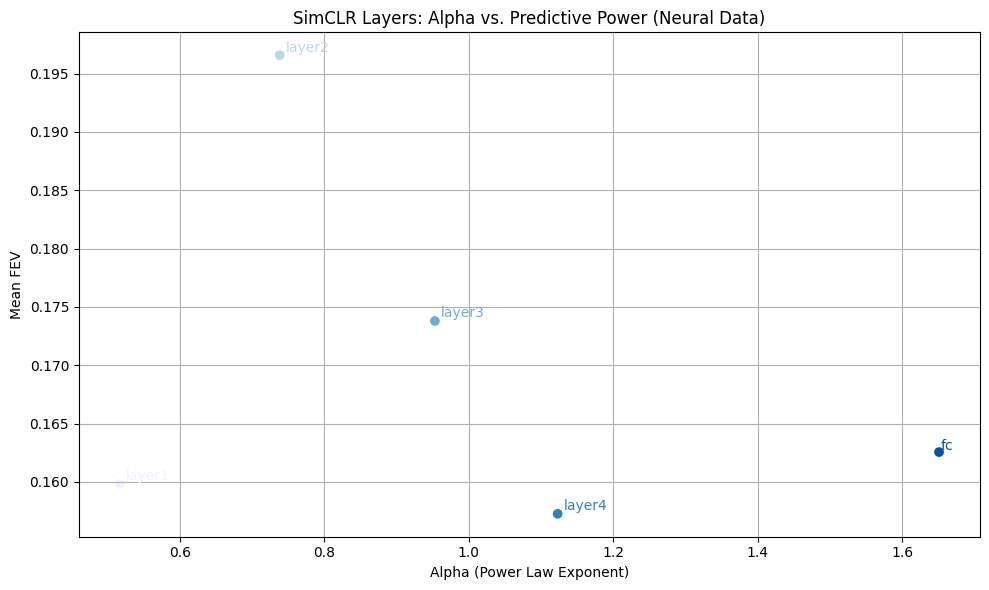

In [15]:
colours = merged_results['layer'].map(simclr_colours)

plt.figure(figsize=(10, 6))
plt.scatter(merged_results['alpha'], merged_results['mean_fev'], c=colours)

texts = []
for _, row in merged_results.iterrows():
    texts.append(
        plt.text(row['alpha'], row['mean_fev'], row['layer'],
                 color=simclr_colours[row['layer']], fontsize=10)
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.xlabel('Alpha (Power Law Exponent)')
plt.ylabel('Mean FEV')
plt.title('SimCLR Layers: Alpha vs. Predictive Power (Neural Data)')
plt.grid(True)
plt.tight_layout()
plt.show()